# Data Scientist Challenge LATAM Airlines

The problem consists in predicting the probability of delay of the flights that land or take off from the airport of Santiago de Chile
(SCL). For that you will have a dataset using public and real data where each row corresponds to a flight that landed or took off
from SCL during 2017. The following information is available for each flight:

In [173]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

data  = pd.read_csv('dataset_SCL.csv')

/tmp/ipykernel_4461/2305514528.py:7: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  data  = pd.read_csv('dataset_SCL.csv')


# 1. How is the data distributed? Did you find any noteworthy insight to share? What can you conclude about this?

In [174]:
data.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [175]:
data['Fecha-I'] = pd.to_datetime(data['Fecha-I'])

In [176]:
# daa distribuida a lo largo de todo el 2017
data['Fecha-I']

0       2017-01-01 23:30:00
1       2017-01-02 23:30:00
2       2017-01-03 23:30:00
3       2017-01-04 23:30:00
4       2017-01-05 23:30:00
                ...        
68201   2017-12-22 14:55:00
68202   2017-12-25 14:55:00
68203   2017-12-27 14:55:00
68204   2017-12-29 14:55:00
68205   2017-12-31 14:55:00
Name: Fecha-I, Length: 68206, dtype: datetime64[ns]

In [177]:
# hay diversidad en las siguentes variables
print('VLO-I ', data['Vlo-I'].nunique(), '\n', 'DES-I' , data['Des-I'].nunique(), '\n', 'Emp-I', data['Emp-I'].nunique())

VLO-I  750 
 DES-I 64 
 Emp-I 30


In [178]:
#todos los vuelos salen de santiago
data['Ori-O'].unique()

array(['SCEL'], dtype=object)

In [179]:
#no solo hay cambios en la hora programada, si no que las otras variables operacionales tambien cambian
(data['Emp-I'] != data['Emp-O']).sum()

18669

In [180]:
#hay datos operacionales del 2018
data['AÑO'].unique()

array([2017, 2018])

In [181]:
# hay datos operacionales del 2018 son despreciables y se deben a pequeños retrasos de año nuevo
data[data['AÑO']==2018]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
66918,2017-12-31 23:55:00,602,SCEL,KLAX,LAN,2018-01-01 00:02:00,602.0,SCEL,KLAX,LAN,1,1,2018,Lunes,I,Grupo LATAM,Santiago,Los Angeles
66947,2017-12-31 23:40:00,622,SCEL,MMMX,LAN,2018-01-01 00:12:00,622.0,SCEL,MMMX,LAN,1,1,2018,Lunes,I,Grupo LATAM,Santiago,Ciudad de Mexico


In [182]:
data['Month-I'] = data['Fecha-I'].dt.strftime('%m')
data['Hour-I'] = data['Fecha-I'].dt.strftime('%H')

In [183]:
data.head(2)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,Month-I,Hour-I
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,01,23
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami,01,23


<AxesSubplot: xlabel='Hour-I', ylabel='Count'>

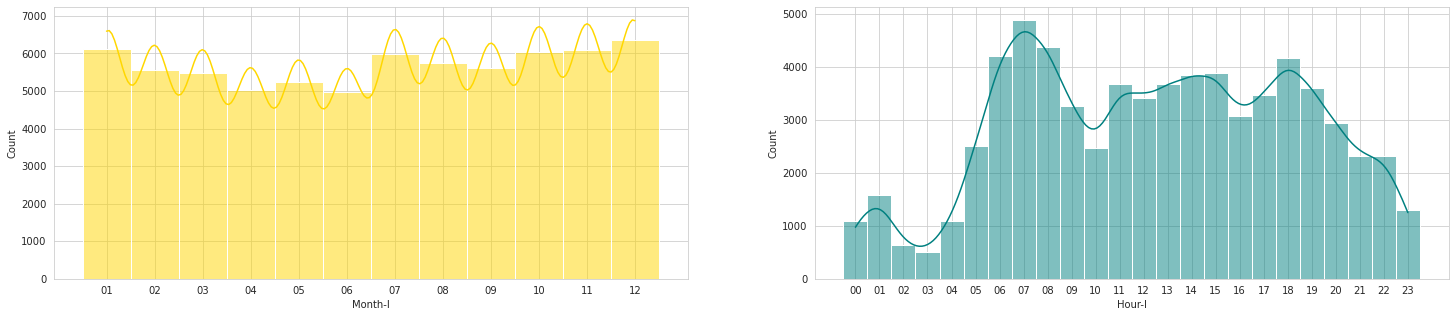

In [184]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5))

sns.histplot(data=data, x='Month-I', kde=True, color="gold", ax=axs[0])
sns.histplot(data=data.sort_values(by=['Hour-I']), x='Hour-I', kde=True, color="teal", ax=axs[1])

<AxesSubplot: xlabel='Count', ylabel='Des-I'>

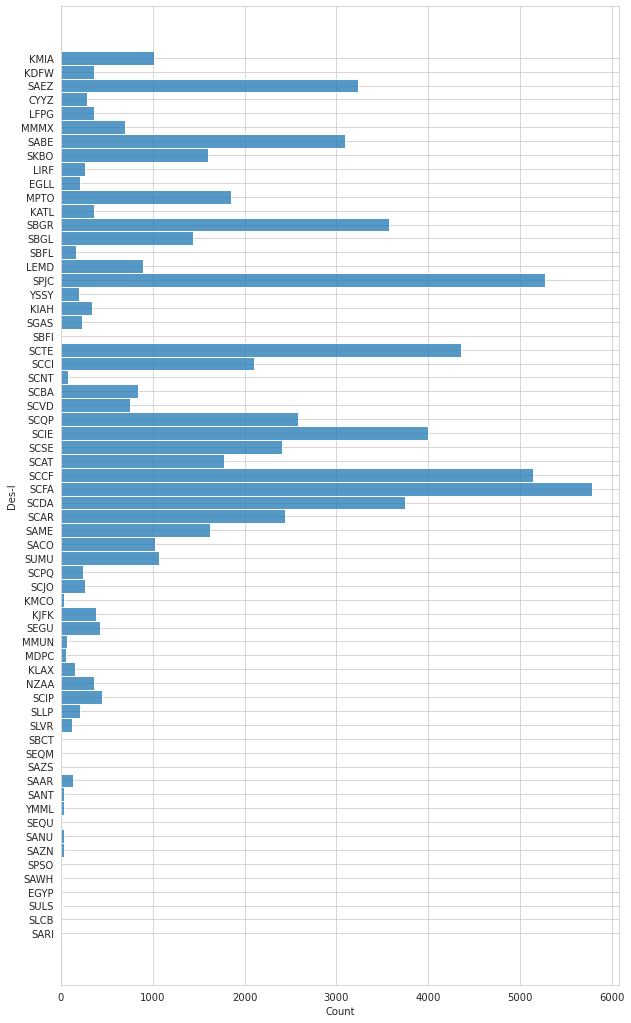

In [185]:
fig, axs = plt.subplots(1, 1, figsize=(10, 18))
sns.set_style("whitegrid")
sns.histplot(y=data['Des-I'])

<AxesSubplot: xlabel='Count', ylabel='Emp-I'>

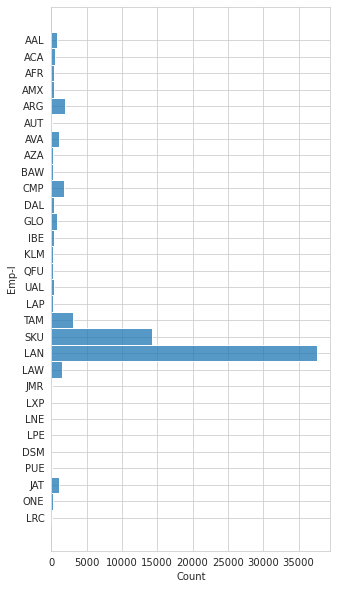

In [186]:
fig, axs = plt.subplots(1, 1, figsize=(5, 10))
sns.set_style("whitegrid")
sns.histplot(y=data['Emp-I'])

# Answer 1:
The data is uniformly distributed throughout the months of the year, with a decrease in flight departures in the early hours of the morning. The scheduled destination shows great diversity, with a widely scattered distribution. Additionally, the airline distribution stands out, with LAN being the primary carrier and SKU being a secondary carrier, which can be attributed to the fact that the client, LATAM, has greater access to their own data.

In other columns, it can be observed that all flights depart from Santiago, Chile. Furthermore, variations between the scheduled and actual flight times are not only time-related, but airline-related as well. It is worth noting that two delays occurred at the end of the last day of 2017, which introduced two data points from 2018 into the actual flight times.

In conclusion, all data is from flights departing from Santiago, with none arriving there, thus the objective will be to predict the probability of delays in departures from Santiago. The time of day and year of the flight departure are dispensable as they do not vary. Additionally, airline and destination variables will be of particular importance due to their non-uniform distributions.

# 2. Generate the following additional columns. Please export them to a CSV file named synthetic_features.csv:

○ high_season : 1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.

○ min_diff : difference in minutes between Date-O and Date-I .

○ delay_15 : 1 if min_diff > 15, 0 if not.

○ period_day : morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based
onDate-I .

In [187]:
# HIGH SEASON
fechas = data['Fecha-I'].dt.strftime('%Y-%m-%d')
high_season_1 = (fechas <= '2017-03-03') | (fechas >= '2017-12-15')
high_season_2 = (fechas <= '2017-07-31') & (fechas >= '2017-15-31')
high_season_3 = (fechas <= '2017-09-30') & (fechas >= '2017-09-11')
high_season = high_season_1 | high_season_2 | high_season_3
data['high_season'] = high_season.astype(int)

In [188]:
# MIN_DIFF
data['Fecha-O'] = pd.to_datetime(data['Fecha-O'])
data['min_diff'] = (data['Fecha-O'] - data['Fecha-I']).dt.total_seconds()/60
data['min_diff'] = data['min_diff'].astype(int)

In [189]:
#DELAY_15
data['delay_15'] = (data['min_diff'] > 15).astype(int)

In [190]:
#PERIOD_DAY
data['period_day'] =  pd.cut(data['Fecha-I'].dt.strftime('%H').astype(int) , bins=[-1, 4, 11, 18, 24], labels=['night', 'morning', 'afternoon', 'night_1'])
data['period_day'] = data['period_day'].apply(lambda x: 'night' if x == 'night_1' else x)

In [191]:
data[['high_season', 'min_diff', 'delay_15', 'period_day']].to_csv('synthetic_features.csv', index=False)

3. What is the behavior of the delay rate across destination, airline, month of the year, day of the week, season, type of flight?What
variables would you expect to have the most influence in predicting delays?

variables utiles como INPUT features:
Fecha-I Vlo-I	Des-I Emp-I TIPOVUELO 

separar los datos de la fecha programanda en 3 variables, y agregar el dia de la semana (lunes-domingo) que representa

4. Train one or several models (using the algorithm(s) of your choice) to estimate the likelihood of a flight delay.
Feel free to generate additional variables and/or supplement with external variables.

5. Evaluate model performance in the predictive task across each model that you trained. Define and justify what metrics you used
to assess model performance. Pick the best trained model and evaluate the following: What variables were the most influential in
the prediction task? How could you improve the
Performance?